In [1]:
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

import torch
from torch.utils.data import TensorDataset, DataLoader
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = torch.load("data/CrI3/20221107.pt")
X = data['param']
Y = torch.cat((data['omega'], data['inten']), dim=1)

In [3]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=1/3, random_state=42)

train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [4]:
model_spec = SpectrumPredictor.load_from_checkpoint("training_logs/lightning_logs/version_1/checkpoints/epoch=9999-step=250000.ckpt")

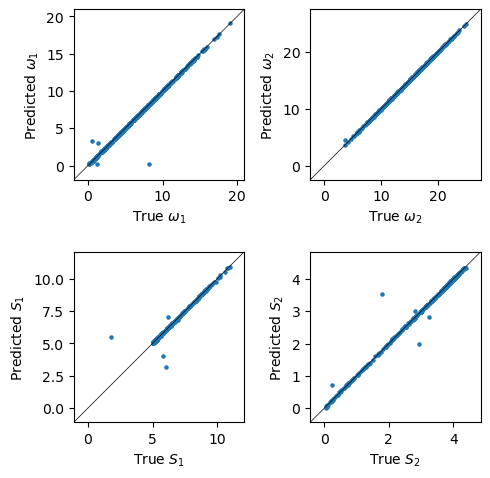

In [5]:
Y_val_pred = []
with torch.no_grad():
    for x_val in X_val:
        Y_val_pred.append(model_spec(x_val).detach())
Y_val_pred = torch.vstack(Y_val_pred)

labels = ['$\omega_1$', '$\omega_2$', '$S_1$', '$S_2$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5)
    ax.scatter(Y_val[:,i], Y_val_pred[:,i], s=5)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_ylim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}")
    ax.set_ylabel(f"Predicted {labels[i]}")

fig.tight_layout()

In [6]:
y_val = Y_val[np.random.choice(len(Y_val))]

omega_val, inten_val = [], []
for i in range(2):
    _omega, _inten = lorentzian(y_val[i], 0.5, y_val[i+2], minimum=0.)
    omega_val.append(_omega); inten_val.append(_inten)
omega_val = torch.cat(omega_val); inten_val = torch.cat(inten_val)

In [7]:
time_val = torch.arange(0,10,0.01)
S_val = batch_spec_to_Sqt(omega_val, inten_val, time_val).sum(dim=1).squeeze()

In [12]:
x_val

tensor([-2.2981, -0.9301, -0.1362])

In [26]:
loss_hist = model_spec.fit_measurement(time_val, S_val, lr=0.025, maxiter=10000)

Iter 9999 Loss 57.027723: 100%|██████████| 10000/10000 [00:36<00:00, 276.43it/s]


In [23]:
import torch.nn.functional as F

batch_size = 10
model_spec.J.data[:] = x_val[0]
model_spec.D.data[:] = x_val[1]
model_spec.K.data[:] = x_val[2]

x = torch.cat((model_spec.J, model_spec.D, model_spec.K), dim=1)
y = model_spec.fc_net(x)
omega, inten = torch.split(y, [model_spec.num_mode, model_spec.num_mode], dim=1)
# batch x mode x time
S_envelope = torch.exp(-torch.einsum("bm,t->bmt", F.relu(model_spec.gamma), time_val))
S_pred = (batch_spec_to_Sqt(omega, inten, time_val) * S_envelope).sum(dim=1)
S_pred = S_pred / S_pred[:,0,None] * S_val[0]
loss = F.mse_loss(S_pred, torch.atleast_2d(S_val).repeat_interleave(batch_size,dim=0).to(S_pred))

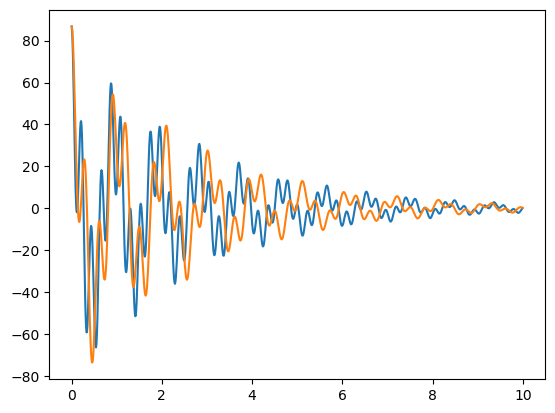

In [24]:
plt.plot(time_val, S_pred.detach().cpu().T[:,0])
plt.plot(time_val, S_val.detach().cpu().T)

In [61]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(r'src/MATLAB/', nargout=0)
J1_list = -np.random.rand(10).astype('float')
eng.generate_data(J1_list,J1_list,J1_list, 'data/CrI3/test/', nargout=0)
eng.quit()

In [62]:
from src.utils_data import mat_to_pt

mat_to_pt('data/CrI3/test', 'data/CrI3/test.pt')

Find 10 files.


100%|██████████| 10/10 [00:00<00:00, 185.68it/s]

Using the k-point  [0.33333333 0.33333333 0.        ]


In [8]:
model_spec.generate_new_data(
    np.random.uniform(-2.5, 0.0, (10,)),
    np.random.uniform(-1.0, 0.0, (10,)),
    np.random.uniform(-6.0, 0.0, (10,)),
    'data/CrI3/test/',
    'data/CrI3/test.pt'
)

Find 10 files.


100%|██████████| 10/10 [00:00<00:00, 111.45it/s]

Using the k-point  [0.33333333 0.33333333 0.        ]


In [12]:
model_spec.train_on_data('data/CrI3/test.pt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | fc_net | Sequential | 18.6 K
--------------------------------------
18.6 K    Trainable params
0         Non-trainable params
18.6 K    Total params
0.074     Total estimated model params size (MB)
c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\pytorch_lightning\trainer\trainer.py:1892: PossibleUserWarning: The number

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 83.55it/s, loss=1.52e-10, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 37.13it/s, loss=1.52e-10, v_num=2]


In [9]:
from optbayesexpt import OptBayesExpt
from src.utils_model import spec_to_Sqt

In [10]:
# Describe how the world works with a model function
#
def my_model_function(sets, pars, cons):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt. In this example, the model function is a
    Lorentzian peak.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    x, = sets
    # unpack model parameters
    x0, a, b = pars
    # unpack model constants
    d, = cons

    # calculate the Lorentzian
    return b + a / (((x - x0) / d) ** 2 + 1)

In [11]:
# Describe how the world works with a model function
#
def model_function(sets, pars, cons):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    # t, = sets
    # unpack model parameters
    J, D, K, tau = sets
    t, = cons

    x = torch.tensor([[J, D, K]])
    y = model_spec(x).cpu()

    omega, inten = torch.split(y, (y.shape[1]//2, y.shape[1]//2), dim=1)
    S = spec_to_Sqt(omega, inten, t).detach().cpu().numpy()
    # calculate the Lorentzian
    return S.sum().item()

In [12]:
sets = (-0.5, -0.5, -0.5, 0.5)
pars = ()
cons = (torch.arange(0,10,0.1), )

In [13]:
model_function(sets, pars, cons)

328.886661211611

In [14]:
import numpy as np

In [15]:
settings = (np.linspace(-2.5, 0, 101), np.linspace(-1.0, 0, 101), np.linspace(-6.0, 0, 101), np.linspace(0, 2, 101))
parameters = (np.random.rand(1001), )
constants = (np.arange(0,10,0.1), )


In [16]:
obe = OptBayesExpt(model_function, settings, parameters, constants)

In [17]:
obe.opt_setting()

C:\Users\zhantao\AppData\Local\Temp\ipykernel_12756\1313523789.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  x = torch.tensor([[J, D, K]])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x104060401 and 3x256)

In [ ]:
x_val = X_val[0]
y_val_pred = model_spec(x_val)

In [ ]:
y_val_pred

tensor([ 6.1968, 16.1807,  5.2981,  3.7198], grad_fn=<SqueezeBackward3>)